In [1]:
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import Dataset, DataLoader
import joblib
import numpy as np
import cv2
from PIL import Image
import os
from torch import tensor
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

class CustomDataset(Dataset):
    def __init__(self,dataframe,image_path):
        self.data = joblib.load(dataframe)
        self.image_path = image_path
        self.W = 512
        self.H = 512
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = os.path.join(self.image_path, row['ImagePath'], row['Filename'])
        image = Image.open(image_path).convert('RGB')
        transform = transforms.ToTensor()
        image_tensor = transform(image)
        
        mask = np.zeros((self.H, self.W), dtype=np.uint8)
        if row['Point'] is not None and row['Point'] != 'None':
            points = row['Point']  # 좌표 문자열 또는 배열
            pts = np.array(points, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [pts], color=int(row['Class']))
        mask_tensor = torch.from_numpy(mask).long()
        return image_tensor, mask_tensor

class Validation_CustomDataset(Dataset):
    def __init__(self,dataframe):
        self.data = joblib.load(dataframe)
        self.W = 512
        self.H = 512
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = os.path.join(row['ImageFile'])
        image = Image.open(image_path).convert('RGB')
        transform = transforms.ToTensor()
        image_tensor = transform(image)
        
        return image_tensor

Train_CustomDataset = CustomDataset('../Dataset/Train_Data.pkl','../Data\Training/01.원천데이터')
valid_CustomDataset = Validation_CustomDataset('../Dataset/Validation_Data.pkl')
valid_CustomDataset[0]

<>:54: SyntaxWarning: invalid escape sequence '\T'
<>:54: SyntaxWarning: invalid escape sequence '\T'
C:\Users\human-02\AppData\Local\Temp\ipykernel_10588\1306861657.py:54: SyntaxWarning: invalid escape sequence '\T'
  Train_CustomDataset = CustomDataset('../Dataset/Train_Data.pkl','../Data\Training/01.원천데이터')


tensor([[[0.9882, 0.9882, 0.9804,  ..., 0.9922, 0.9882, 0.9882],
         [0.9882, 0.9765, 0.9922,  ..., 0.9882, 0.9922, 0.9961],
         [0.9882, 0.9882, 0.9882,  ..., 0.9922, 0.9922, 0.9961],
         ...,
         [1.0000, 0.9961, 1.0000,  ..., 0.9882, 1.0000, 0.9882],
         [0.9922, 0.9961, 1.0000,  ..., 0.9961, 1.0000, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 0.9765]],

        [[0.9843, 0.9882, 0.9843,  ..., 0.9882, 0.9882, 0.9922],
         [0.9961, 0.9882, 0.9882,  ..., 0.9922, 0.9922, 1.0000],
         [0.9804, 0.9922, 0.9843,  ..., 0.9882, 0.9961, 0.9882],
         ...,
         [1.0000, 0.9961, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
         [1.0000, 0.9922, 0.9961,  ..., 0.9882, 0.9882, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9725, 0.9843, 0.9922,  ..., 0.9882, 0.9961, 0.9686],
         [1.0000, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 0.9961],
         [0.9961, 1.0000, 0.9922,  ..., 0.9922, 0.9961, 0.

In [2]:
img = Image.open(r'C:\Users\human-02\Desktop\X_ray_Segmentation\Data\Training\01.원천데이터\TS_1.질환_1.선천성유문협착증\1_0003.png')
np.array(img).shape

(512, 512, 3)

In [5]:
num_classes = 5
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256,num_classes,kernel_size=1)
model = model.to('cuda')

c:\Users\human-02\AppData\Local\anaconda3\envs\FirstProject\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\human-02\AppData\Local\anaconda3\envs\FirstProject\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to C:\Users\human-02/.cache\torch\hub\checkpoints\deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:15<00:00, 10.6MB/s] 


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(Train_CustomDataset, batch_size=4, shuffle=True)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    
    epoch_loss = 0
    correct_pixels = 0
    total_pixels = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, masks in loop:
        images, masks = images.to('cuda'), masks.to('cuda')

        optimizer.zero_grad()
        outputs = model(images)['out']  # (N, C, H, W)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Accuracy 계산: 예측 클래스 == 실제 클래스
        preds = torch.argmax(outputs, dim=1)  # (N, H, W)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += torch.numel(masks)

        loop.set_postfix(batch_loss=loss.item())

    epoch_avg_loss = epoch_loss / len(train_loader)
    epoch_acc = correct_pixels / total_pixels * 100
    
    print(f"\n[Epoch {epoch+1}] Loss: {epoch_avg_loss:.4f} | Accuracy: {epoch_acc:.2f}%\n")

c:\Users\human-02\AppData\Local\anaconda3\envs\FirstProject\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\human-02\AppData\Local\anaconda3\envs\FirstProject\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


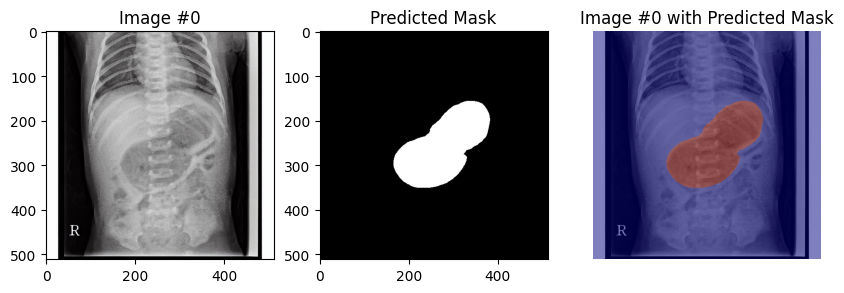

<Figure size 640x480 with 0 Axes>

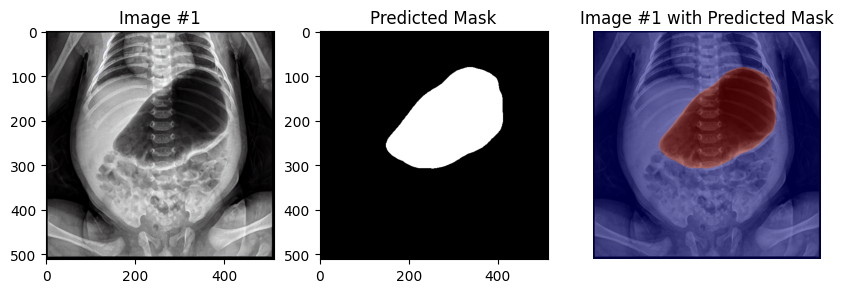

<Figure size 640x480 with 0 Axes>

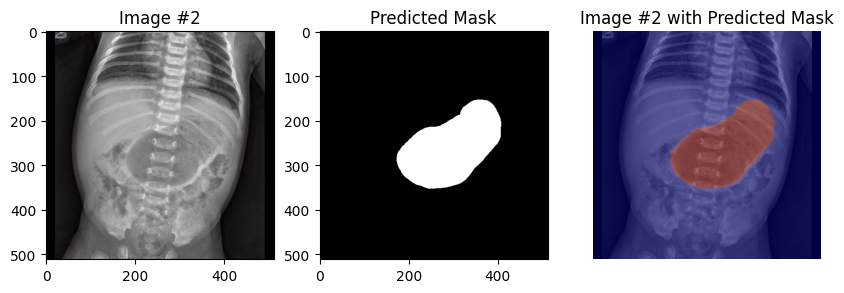

<Figure size 640x480 with 0 Axes>

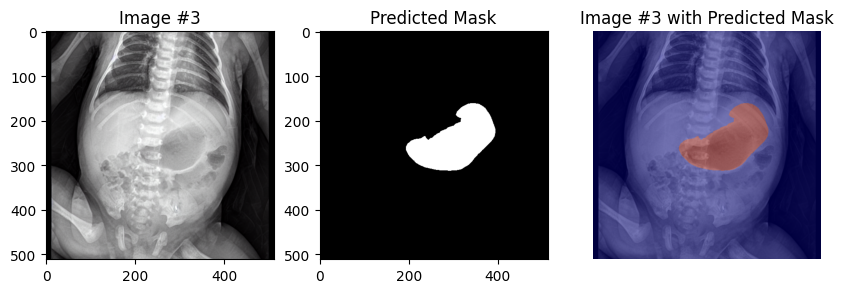

<Figure size 640x480 with 0 Axes>

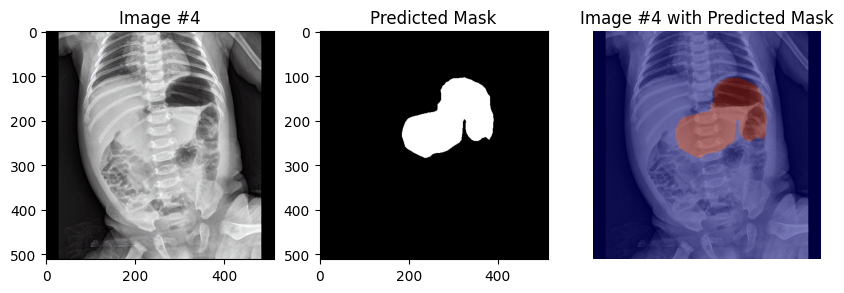

<Figure size 640x480 with 0 Axes>

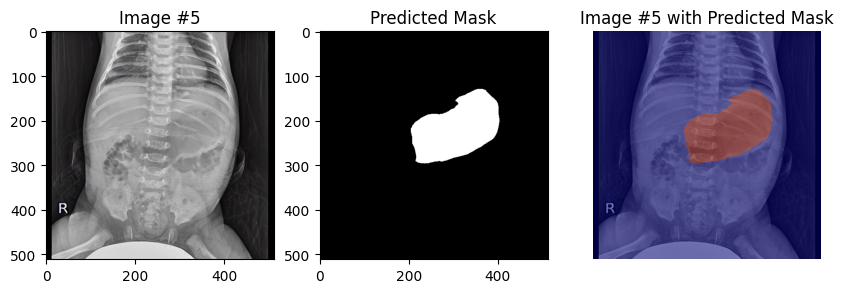

<Figure size 640x480 with 0 Axes>

In [ ]:
# torch.save(model.state_dict(),"Best_model.pth")
num_classes = 5
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256,num_classes,kernel_size=1)
model = model.to('cpu')
model.load_state_dict(torch.load('Best_model.pth', map_location=torch.device('cpu')))
model.eval()
ValidationLoader = DataLoader(valid_CustomDataset, batch_size=1, shuffle=False)

for idx,image_tensor in enumerate(ValidationLoader):
    with torch.no_grad():
        image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)
        output = model(image_tensor.to('cpu'))['out']
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
        # 시각화
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"Image #{idx}")

        plt.subplot(1, 3, 2)
        plt.imshow(pred, cmap='gray')
        plt.title("Predicted Mask")

        
        plt.subplot(1, 3, 3)
        plt.imshow(image)  # 원본 이미지
        plt.imshow(pred, cmap='jet', alpha=0.5)  # 예측 마스크 (반투명하게)
        plt.title(f"Image #{idx} with Predicted Mask")
        plt.axis('off')
        plt.show()
        
        plt.tight_layout()
        plt.show()

        # 사용자 입력 대기 (Enter 눌러야 다음 이미지로 넘어감)
        inputs = input("Press Enter to show next image...")
        if inputs == 'end':
            break

정확도 97%

In [20]:
model.eval()
dummy_input = torch.randn(1,3,512,512).to('cpu')
model.to('cpu')

torch.onnx.export(
    model,
    dummy_input,
    "DeepLabv3_ONNXModel.onnx",
    input_names=['input'], # C#에서 입력으로 사용
    output_names=['output'], # 출력이름
    dynamic_axes={ 
        'input':{0:'batch_size'},
        'output':{0:'batch_size'}
    }, # 배치 크기를 동적으로 처리 [?,C,H,W]
    export_params=True,
    opset_version=11,
    do_constant_folding=True
)

In [31]:
dummy_input = Image.open('../Data\Validation\\01.원천데이터\VS_1.질환_2.기복증\\2_1872.png')
dummy_input = np.array(dummy_input)/255.0
dummy_input

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.00784314, 0.        , 0.00784314],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.00392157, 0.        , 0.        ],
        [0.        , 0

# ONNX 모델이 정말 잘 동작하는지 확인
- ONNX는 모르는 영역이라 ChatGPT의 도움을 받았다.


✅ ONNX 모델 구조 및 형식 검증 통과
입력 이름: input, 출력 이름: output
출력 shape: (1, 5, 512, 512)
클래스 0 픽셀 개수: 232932
클래스 1 픽셀 개수: 29212


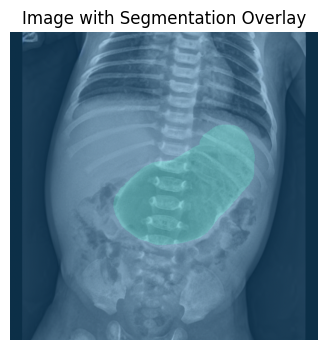

In [61]:
import onnx
import onnxruntime as ort
import numpy as np

# ✅ 모델 로드 및 검증
onnx_model = onnx.load("DeepLabv3_ONNXModel.onnx")
onnx.checker.check_model(onnx_model)
print("✅ ONNX 모델 구조 및 형식 검증 통과")

# ✅ ONNX Runtime 세션 생성
ort_session = ort.InferenceSession("DeepLabv3_ONNXModel.onnx")

# ✅ 입력 이름 확인 (모델 내 정의된 이름 확인)
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name
print(f"입력 이름: {input_name}, 출력 이름: {output_name}")

# ✅ 테스트용 dummy 입력 생성 (예: (1, 3, 224, 224) 이미지)
dummy_input = Image.open('../Data\Validation\\01.원천데이터\VS_1.질환_1.선천성유문협착증\\1_1816.png')
tensor_image = transforms.ToTensor()(dummy_input)
dummy_input = tensor_image.unsqueeze(0).numpy()

# ✅ ONNX 추론 실행
outputs = ort_session.run([output_name], {input_name: dummy_input})

# ✅ 출력 결과 확인
print("출력 shape:", outputs[0].shape)
dummy_input_img = dummy_input[0].transpose(1,2,0)  # (3,H,W) -> (H,W,3)

# 2) ONNX 출력 (1, 5, 512, 512)
output = outputs[0]
pred_mask = np.argmax(output, axis=1)[0]  # (512,512)

# 3) 컬러맵 생성 (클래스별 색상)
cmap = plt.get_cmap('tab10')
mask_color = cmap(pred_mask / pred_mask.max())  # (512,512,4) RGBA

# 4) 어떤 클래스인지 확인
unique_classes, counts = np.unique(pred_mask, return_counts=True)
for cls, cnt in zip(unique_classes, counts):
    print(f"클래스 {cls} 픽셀 개수: {cnt}")
    
# 4) 시각화 (원본 + 마스크 투명하게 겹치기)
plt.figure(figsize=(4,4))
plt.imshow(dummy_input_img)              # 원본 이미지
plt.imshow(mask_color, alpha=0.4)       # 마스크 투명도 조절 (0.0~1.0)
plt.axis('off')
plt.title('Image with Segmentation Overlay')
plt.show()